In [6]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools

from ht_simNy import sim1d

import seaborn as sns

from pyDOE2 import fullfact
from pyDOE2 import fracfact

import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import ttest_ind

from SALib.sample import saltelli
from SALib.analyze import sobol

In [7]:
#Create a fractional factorial design

from pyDOE2 import fracfact

num_levels = 2
levels = [0, 1]
num_vars = 11
design2 = fracfact('a b c d e f g h abcd abce abde')
L_level = 0.99
R_level = 1.01
perc_change = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 1.0, 0.03, 0.60, 0.30,0.30]
factor_levels = {
    'rho_l': [2760.0, 2760.0 * (1 + perc_change[0])],
    'rho_s': [3000.0, 3000.0 * (1 + perc_change[1])],
    'k_l': [96.0, 96.0 * (1 + perc_change[2])],
    'k_s': [110.0,  110.0 * (1 + perc_change[3])],
    'cp_l': [927.0, 927.0* (1 + perc_change[4])],
    'cp_s': [967.0, 967.0 * (1 + perc_change[5])],
    'Surr_temp': [313.0, 313.0 * (1 + perc_change[6])],
    'L_fusion': [389e3, 389e3 * (1 + perc_change[7])],
    'temp_init': [880.0, 880.0 * (1 + perc_change[8])],
    'heat_transfer_coefficient_left': [10.0, 10.0 * (1 + perc_change[9])],
    'heat_transfer_coefficient_right': [11.0, 10.0 * (1 + perc_change[10])],
}

factor_names = list(factor_levels.keys())

# Create a DataFrame from the fractional factorial design
doe_df_sol_time_fracfact = pd.DataFrame(design2, columns=factor_names)

for factor, levels in factor_levels.items():
    doe_df_sol_time_fracfact[factor] = doe_df_sol_time_fracfact[factor].map({-1: levels[0], 1: levels[1]})

    
print(doe_df_sol_time_fracfact.shape)

(256, 11)


In [8]:
df_results = pd.read_csv('Fractional_Factorial_doe_center_pt.csv')

In [9]:
problem = {
    'num_vars': len(factor_names), # Number of factors
    'names': factor_names,
    'bounds': [factor_levels[factor] for factor in factor_names]
    
}

Y = df_results['Lowest_Niyama'].values
print(Y.shape)
X = df_results[factor_names].values
print(X.shape)

# Ensure that the response variable matches the input matrix
assert X.shape[0] == Y.shape[0], "Number of samples in X and Y must be the same"


# Si = sobol.analyze(problem, Y, calc_second_order =True, print_to_console=True)

# Perform a basic analysis without second-order effects
try:
    Si = sobol.analyze(problem, Y, calc_second_order=False, print_to_console=True)

    # Create a DataFrame with the Sobol indices
    Si_df = pd.DataFrame({
        'Factor': problem['names'],
        'S1': Si['S1'],
        'ST': Si['ST'],
        'S1_conf': Si['S1_conf'],
        'ST_conf': Si['ST_conf']
    })

    # Display the Sobol indices
    print(Si_df)

    # Save the Sobol indices to a CSV file
    Si_df.to_csv('sobol_sensitivity_analysis_results.csv', index=False)
    print("Sobol sensitivity analysis results saved to 'sobol_sensitivity_analysis_results.csv'")
except RuntimeError as e:
    print(f"RuntimeError: {e}")

(257,)
(257, 11)
RuntimeError: 
        Incorrect number of samples in model output file.
        Confirm that calc_second_order matches option used during sampling.


/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.9/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [10]:
def calculate_sensitivity_indices(X, Y):
    # Placeholder function for sensitivity analysis
    # Implement actual calculation here based on the custom design
    num_samples, num_factors = X.shape
    S1 = np.zeros(num_factors)
    ST = np.zeros(num_factors)

    # Simple example of calculating sensitivity (replace with actual method)
    for i in range(num_factors):
        X1 = np.copy(X)
        X1[:, i] = np.mean(X[:, i])
        Y1 = np.mean(Y)

        S1[i] = np.var(Y1) / np.var(Y)
        ST[i] = 1 - (np.var(Y) - np.var(Y1)) / np.var(Y)

    return S1, ST

# Calculate sensitivity indices
S1, ST = calculate_sensitivity_indices(X, Y)

# Create a DataFrame with the sensitivity indices
sensitivity_df = pd.DataFrame({
    'Factor': factor_names,
    'S1': S1,
    'ST': ST
})

# Display the sensitivity indices
print(sensitivity_df)

# Save the sensitivity indices to a CSV file
sensitivity_df.to_csv('custom_sensitivity_analysis_results.csv', index=False)
print("Custom sensitivity analysis results saved to 'custom_sensitivity_analysis_results.csv'")


                             Factor   S1   ST
0                             rho_l  0.0  0.0
1                             rho_s  0.0  0.0
2                               k_l  0.0  0.0
3                               k_s  0.0  0.0
4                              cp_l  0.0  0.0
5                              cp_s  0.0  0.0
6                         Surr_temp  0.0  0.0
7                          L_fusion  0.0  0.0
8                         temp_init  0.0  0.0
9    heat_transfer_coefficient_left  0.0  0.0
10  heat_transfer_coefficient_right  0.0  0.0
Custom sensitivity analysis results saved to 'custom_sensitivity_analysis_results.csv'


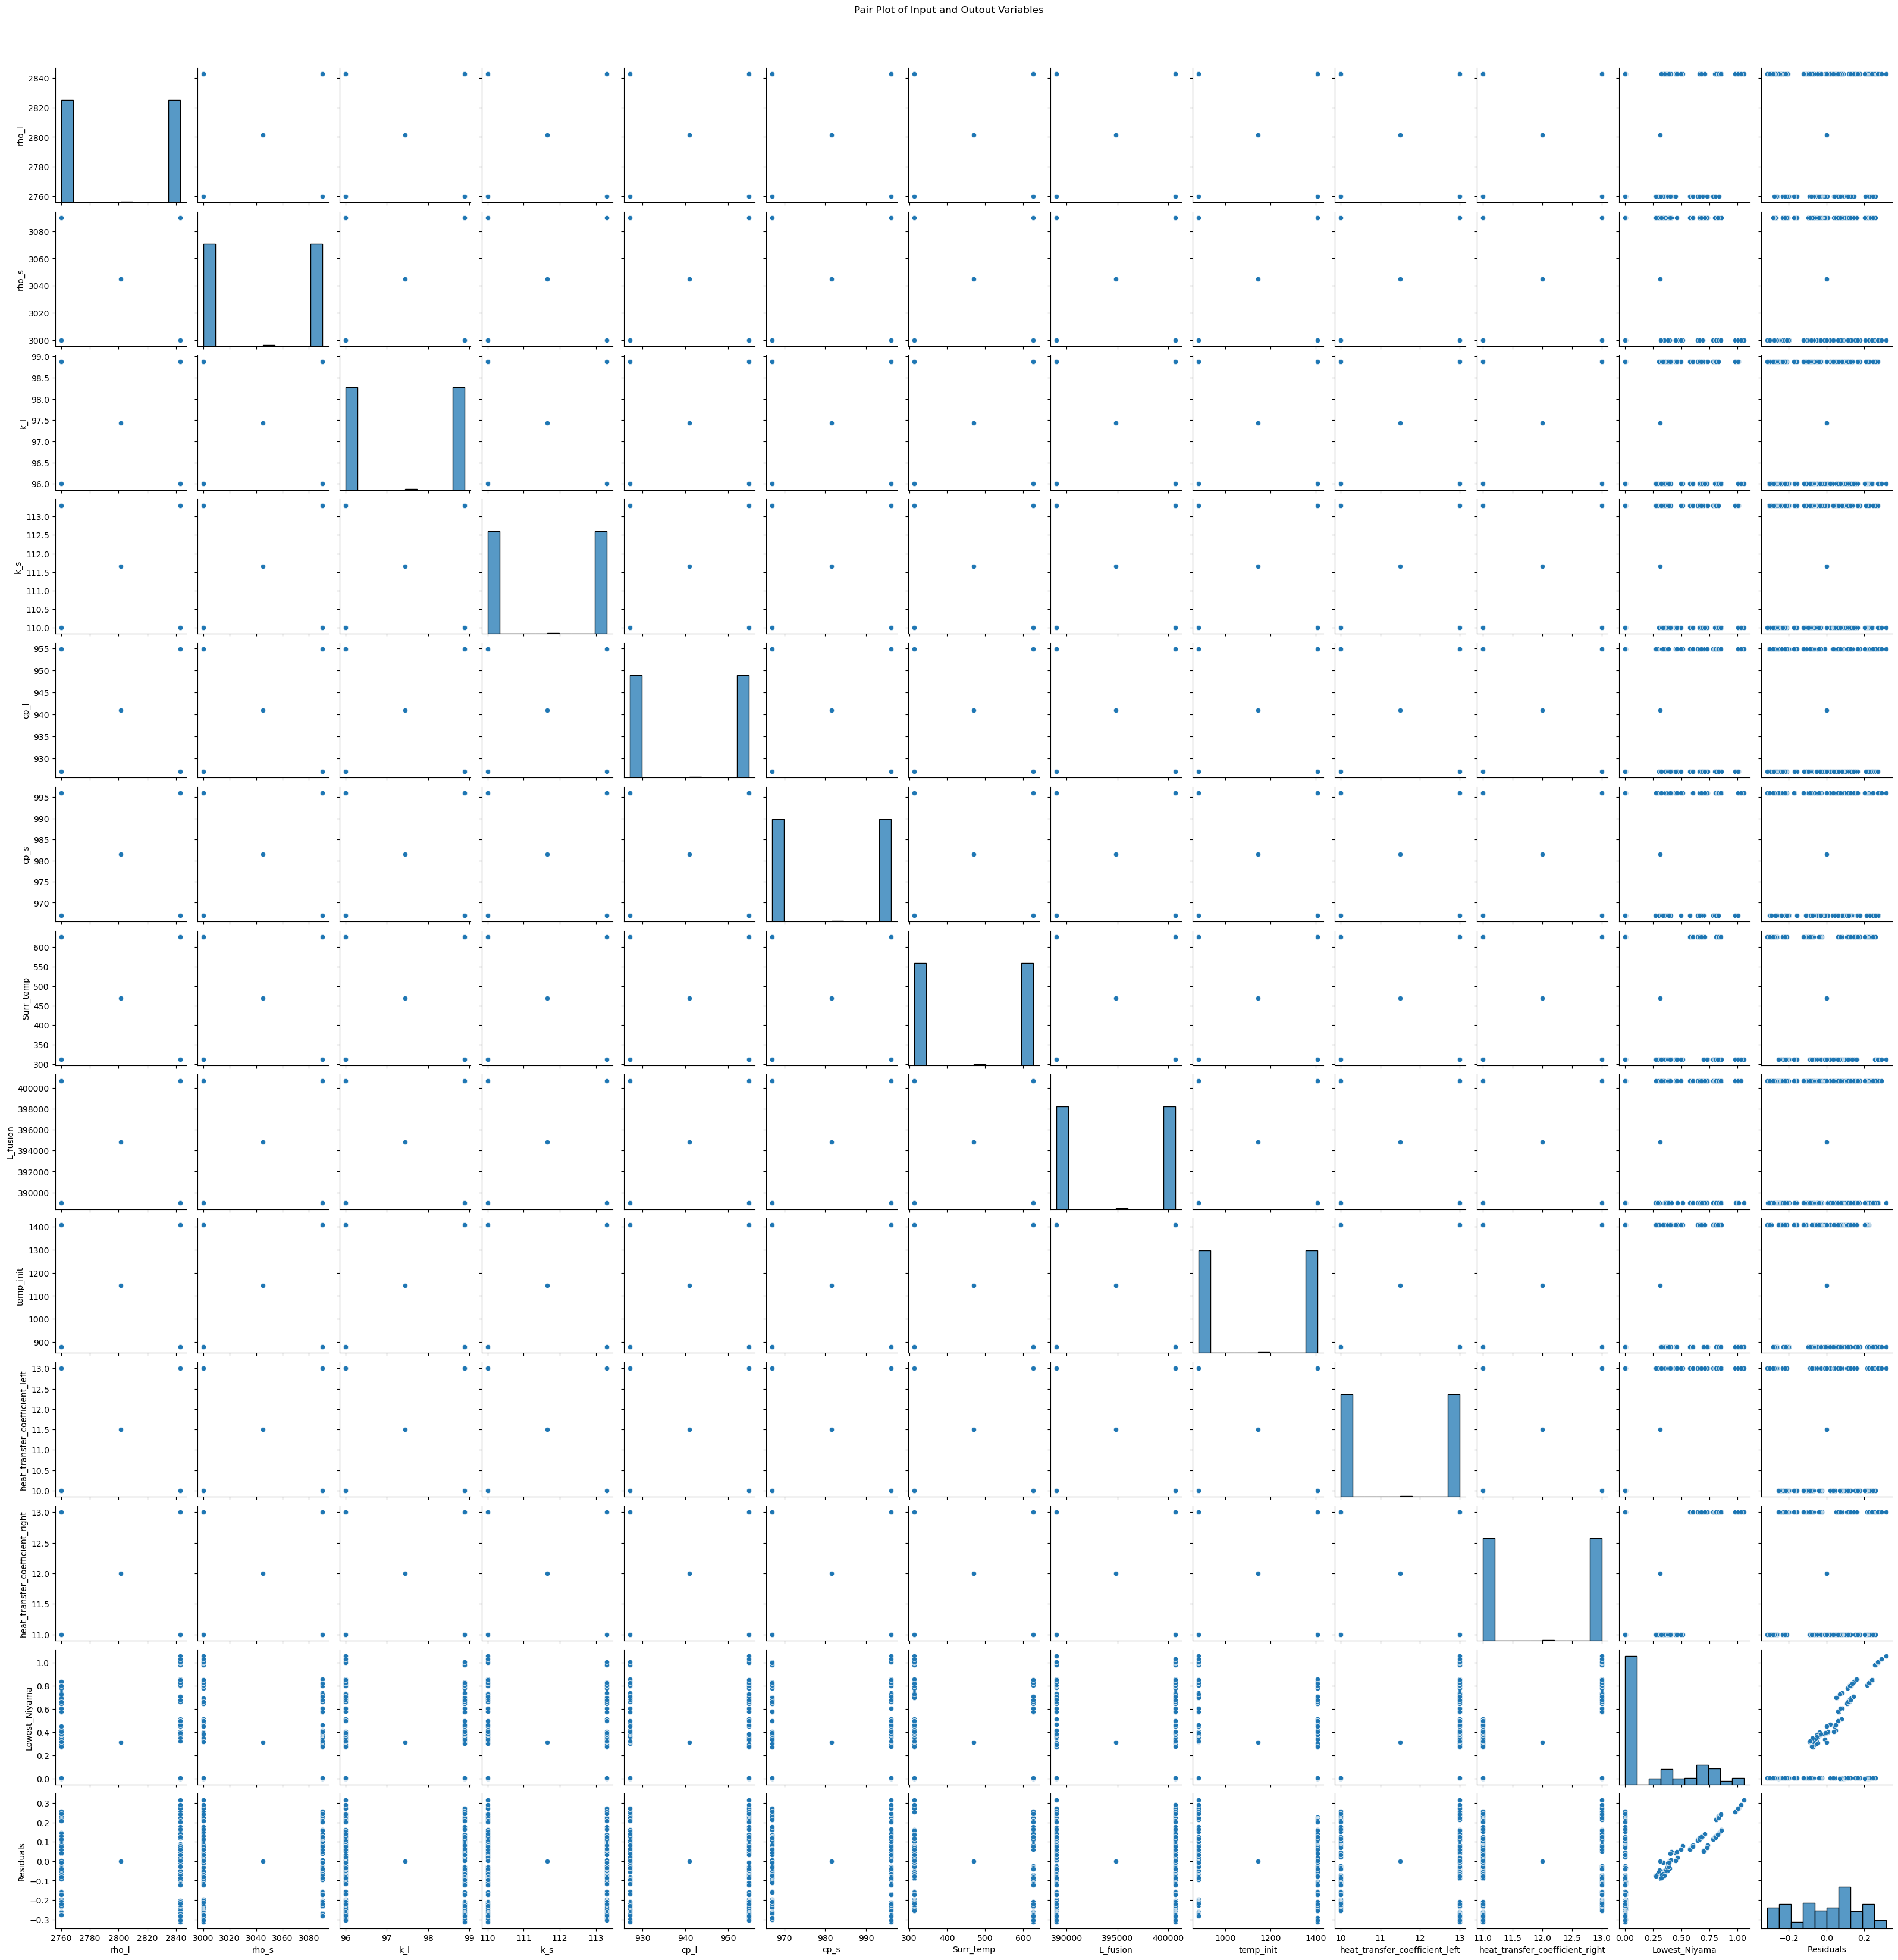

In [11]:
sns.pairplot(df_results)
plt.suptitle('Pair Plot of Input and Outout Variables',y =1.02)
plt.show()